###  Problem statement

- Create a model for predicting wheather email is spam or ham

**1. Importing Libraries**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import nltk
import re
import emoji
from collections import Counter
from wordcloud import WordCloud
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import PorterStemmer,LancasterStemmer,SnowballStemmer,WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer,PowerTransformer,StandardScaler,LabelEncoder

**2. Data Collection**

In [6]:
data = pd.read_csv(r"/content/drive/MyDrive/spam.csv", encoding= 'latin-1', usecols = ["v1","v2"])

In [7]:
df = data.copy()

In [8]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df.shape

(5572, 2)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [11]:
df.isnull().sum()

v1    0
v2    0
dtype: int64

In [12]:
df.duplicated().sum()

403

In [13]:
df.drop_duplicates(keep= "first", inplace= True)

In [14]:
df.duplicated().sum()

0

In [15]:
df['v1'].value_counts()

ham     4516
spam     653
Name: v1, dtype: int64

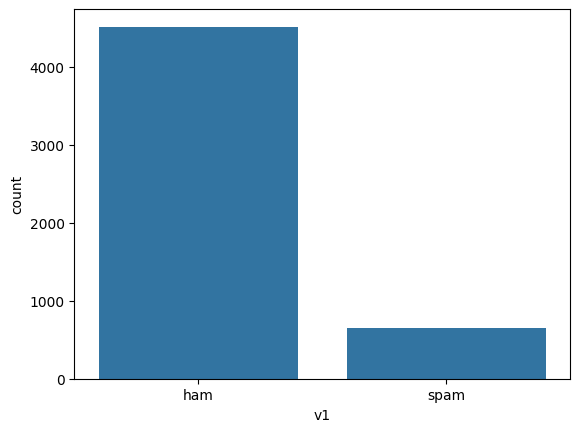

In [16]:
sns.countplot(data= df, x= 'v1')
plt.show()

In [17]:
feature_var = df['v2']

In [18]:
feature_var.head()

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: v2, dtype: object

In [19]:
def EDA_1(data):

    case = " ".join(data).islower()
    html = data.apply(lambda x:True if re.search("<.+?>",x) else False).sum()
    url = data.apply(lambda x:True if re.search("http[s]?://.+? +",x) else False).sum()
    unwanted = data.apply(lambda x:True if re.search("[]()*\-.:,@#$%&^!?/0-9']",x) else False).sum()

    count = 0
    for sen in data:
        for char in sen.split():
            if emoji.is_emoji(char):
                count += 1

    if case == False:
        print("Contains non lowercase letters")
    else:
        print('All are in lowercase letters')

    if html > 0:
        print("Contains html tags")
    else:
        print('No html tags')

    if url > 0:
        print("Contains urls")
    else:
        print('No urls')

    if unwanted > 0:
        print("Contains unwanted characters")
    else:
        print('No unwanted characters')

    if count > 0:
        print('Contains Emoji')
    else:
        print('No Emoji')

In [20]:
EDA_1(feature_var)

Contains non lowercase letters
Contains html tags
Contains urls
Contains unwanted characters
No Emoji


In [21]:
class_var = df['v1']

In [22]:
class_var.head()

0     ham
1     ham
2    spam
3     ham
4     ham
Name: v1, dtype: object

In [23]:
class_var_encoding = LabelEncoder()

class_var = class_var_encoding.fit_transform(class_var)

class_var = pd.Series(class_var)

In [24]:
class_var.head()

0    0
1    0
2    1
3    0
4    0
dtype: int64

In [25]:
x_train,x_test,y_train,y_test = train_test_split(feature_var, class_var, test_size= 0.2, random_state= 7, stratify= class_var)

In [26]:
x_train,x_cv,y_train,y_cv = train_test_split(x_train, y_train, test_size= 0.2, random_state= 1, stratify= y_train)

In [27]:
x_train.head()

2590    Lol I have to take it. member how I said my au...
4303    Good good, billy mates all gone. Just been jog...
3974    do u think that any girl will propose u today ...
1254                           What your plan for pongal?
3394                                          Then i buy.
Name: v2, dtype: object

**4. Pre-Processing**

In [28]:
def emoji_remove(x):

    x = x.apply(lambda x : emoji.demojize(x))

    return x

In [29]:
def lowercase(x):

     return x.str.lower()

In [30]:
def html_tags(x):

    x = x.apply(lambda x:re.sub("<.+?>"," ",x))

    return x

In [31]:
def urls(x):

    x = x.apply(lambda x : re.sub("https[s]?://.+? +"," ",x))

    return x

In [32]:
def unwanted_characters(x):

    x = x.apply(lambda x : re.sub("[]()*\-.:,@#$%&^!?/0-9']"," ",x))

    return x

In [33]:
def lemmatization(x):

    list_stp = stopwords.words("english")
    wl = WordNetLemmatizer()

    def lemmatize_text(text):

        words = word_tokenize(text)
        lemmatized_words = [wl.lemmatize(word, pos="v") for word in words if word not in list_stp]

        return " ".join(lemmatized_words)

    return x.apply(lemmatize_text)

In [34]:
preprocesser_pipe = Pipeline([('Lowercase', FunctionTransformer(lowercase)),
                              ('Html_Tags', FunctionTransformer(html_tags)),
                              ('Urls', FunctionTransformer(urls)),
                              ("Emoji's", FunctionTransformer(emoji_remove)),
                              ('Unwanted Characters', FunctionTransformer(unwanted_characters)),
                              ('Lemmatization',FunctionTransformer(lemmatization))])

**5. EDA After Pre-Processing**

In [39]:
x_train = preprocesser_pipe.fit_transform(x_train)

eda_feature_var = pd.DataFrame(list(x_train), columns= ['Eamil'])

eda_class_var = pd.DataFrame(list(y_train), columns= ['spam or ham'])

eda_df = pd.concat([eda_feature_var, eda_class_var], axis= 1)

In [40]:
eda_df.head()

,Eamil,spam or ham
0,lol take member say aunt flow visit months cau...,0
1,good good billy mat go jog enjoy concert,0
2,u think girl propose u today see ur bloody fun...,0
3,plan pongal,0
4,buy,0


In [41]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3308 entries, 0 to 3307
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Eamil        3308 non-null   object
 1   spam or ham  3308 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 51.8+ KB


In [42]:
group_df = eda_df.groupby('spam or ham')

ham_data = group_df.get_group(0)['Eamil']

spam_data = group_df.get_group(1)['Eamil']

In [43]:
ham_data_words = ' '.join(ham_data).split()

spam_data_words = ' '.join(spam_data).split()

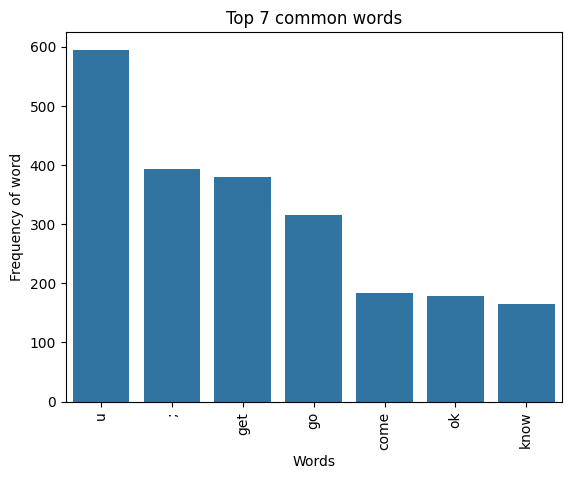

In [44]:
words = []
freq = []
for i,j in Counter(ham_data_words).most_common(7):
    words.append(i)
    freq.append(j)
sns.barplot(x= words, y= freq)
plt.xlabel('Words')
plt.ylabel('Frequency of word')
plt.title('Top 7 common words')
plt.xticks(rotation = 90)
plt.show()

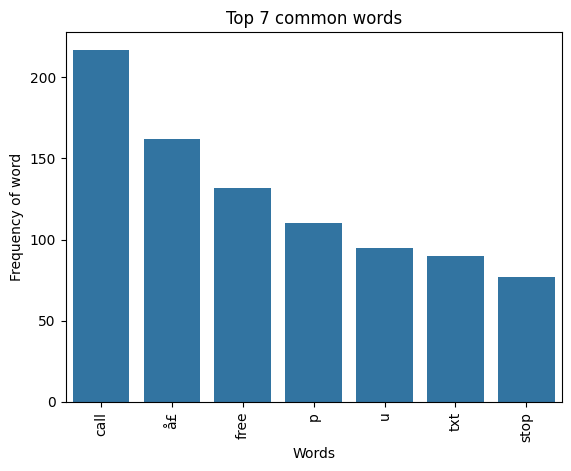

In [45]:
words = []
freq = []
for i,j in Counter(spam_data_words).most_common(7):
    words.append(i)
    freq.append(j)
sns.barplot(x= words, y= freq)
plt.xlabel('Words')
plt.ylabel('Frequency of word')
plt.title('Top 7 common words')
plt.xticks(rotation = 90)
plt.show()

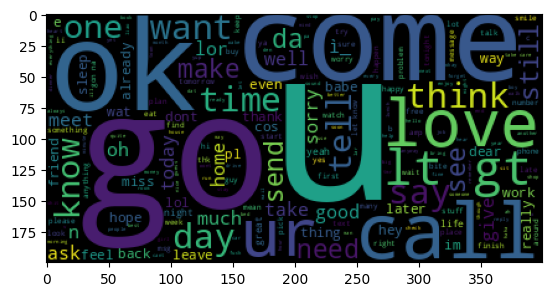

In [46]:
wc = WordCloud().generate(' '.join(ham_data))
plt.imshow(wc)
plt.show()

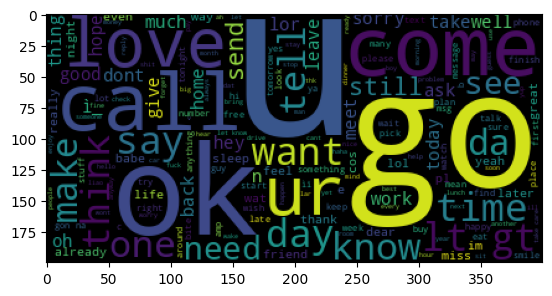

In [47]:
wc = WordCloud().generate(' '.join(ham_data))
plt.imshow(wc)
plt.show()

**6. Feature Engineering**

In [48]:
feature_extraction_pipe = Pipeline([('Pre-Processing',preprocesser_pipe),
                                    ('Vectorization',CountVectorizer())])

In [49]:
final_x_train = feature_extraction_pipe.fit_transform(x_train)

final_x_cv = feature_extraction_pipe.transform(x_cv)

final_x_test = feature_extraction_pipe.transform(x_test)

In [50]:
pickle.dump(feature_extraction_pipe,open(r"/content/drive/MyDrive/spam_feature_extraction.pkl",'wb'))

**7. Training & Evalution**

In [51]:
for i in range(1,10):
    multi = MultinomialNB(alpha= i)
    model = multi.fit(final_x_train,y_train)
    print(('*'*18 + ' Alpha - {} ' + '*'*18).format(i))
    print(classification_report(y_train, model.predict(final_x_train)))

****************** Alpha - 1 ******************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2890
           1       0.97      0.99      0.98       418

    accuracy                           0.99      3308
   macro avg       0.99      0.99      0.99      3308
weighted avg       0.99      0.99      0.99      3308

****************** Alpha - 2 ******************
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2890
           1       0.97      0.96      0.97       418

    accuracy                           0.99      3308
   macro avg       0.98      0.98      0.98      3308
weighted avg       0.99      0.99      0.99      3308

****************** Alpha - 3 ******************
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2890
           1       0.98      0.94      0.96       418

    accuracy                          

In [52]:
for i in range(1,10):
    multi = MultinomialNB(alpha= i)
    model = multi.fit(final_x_train,y_train)
    print(('*'*18 + ' Alpha - {} ' + '*'*18).format(i))
    print(classification_report(y_cv, model.predict(final_x_cv)))

****************** Alpha - 1 ******************
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       723
           1       0.92      0.93      0.93       104

    accuracy                           0.98       827
   macro avg       0.96      0.96      0.96       827
weighted avg       0.98      0.98      0.98       827

****************** Alpha - 2 ******************
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       723
           1       0.94      0.92      0.93       104

    accuracy                           0.98       827
   macro avg       0.97      0.96      0.96       827
weighted avg       0.98      0.98      0.98       827

****************** Alpha - 3 ******************
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       723
           1       0.97      0.92      0.95       104

    accuracy                          

**8. Testing**

In [53]:
multi = MultinomialNB(alpha= 1)
final_model = multi.fit(final_x_train,y_train)

In [54]:
print(classification_report(y_test, model.predict(final_x_test)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       903
           1       1.00      0.77      0.87       131

    accuracy                           0.97      1034
   macro avg       0.98      0.89      0.93      1034
weighted avg       0.97      0.97      0.97      1034



### 9. Deploying

In [55]:
pickle.dump(final_model,open(r"/content/drive/MyDrive/spam_model.pkl",'wb'))

In [56]:
m = feature_extraction_pipe.transform(x_test.iloc[[1]])
pred = final_model.predict(m)

if pred == 1:
  print("spam")
else:
  print("ham")

ham
